![](https://i.pinimg.com/originals/0f/57/41/0f5741c61305fa3489653c7650c94658.jpg)
<a name="introduction"></a>

In this project, I am going to start learning how to do web scraping. I am planning to web scrape iMDB and Rotten Tomato to get info about each movie.  My aim is to collect as much data as possible. This will be a continuous project with the implementation of machine learning and NLP. We will start with machine learning section and try to predict the movie score based on all the info we collect from those two websites. Let's get started. 


# Objectives
- [Introduction](#introduction)
- [Import necessary modules](#modules)
- [Imdb_webscraping_part#1](#imdb1)
- [Imdb_webscraping_part#2](#imdb2)
- [Rotten tomato webscraping](#Rotten tomato webscraping)
- [Cleaning All datasets(This is the starting point of this project after collecting all the data)](#cleaning_data_sets)
- [Visualization](#visualization)
- [Feature Engineering](#feature_engineering)
- [Train-test split](#train_test_split)
- [Creating models](#creating_models)
- [Result metrics](#result_metrics)
- [Feature Importance](#feature_importance)
- [ROC/AUC curve](#roc_auc_curve)
- [Wrapping Up](#wrapping_up)
- [Next](#next)


#### Importing all the necessary modules
<a name="#modules"></a>

We are start out by importing a bunch of libraries that will help us with the task.  

In [1]:
## Importing necessary modules
import csv  # # Working with CSV.
import re  # # Regular Expression.
import time  # # Time the code.

import numpy as np  # # Helps to do most of the linear algebra work.
import pandas as pd
import requests  # # requests is used to do web scraping.
from bs4 import BeautifulSoup  # # Library that printed html object nicely.

pd.set_option('display.max_columns', 500) ## to see all the columns,
pd.set_option('display.max_rows', 500) ## To see all the rows. 

import warnings ## importing warnings library. 
warnings.filterwarnings('ignore') ## Ignore warning

# Collecting Data

#### Imdb webscraping part #1
<a name="imdb1"></a>




In [2]:
## Some functions to extract data
def metascore_getter_class(css_class):
    return (css_class == "metascore mixed" 
            or css_class == "metascore favorable" 
            or css_class=="metascore unfavorable")

    

In [3]:
%%time
## Looping through each page of the IMDB website which consists of 50
##movies in each page, picking movies only with more than 1000 votes 
#and a rating higher than 9 and lower than 5


## Whenever we use "nested for loops" it exponentially increase our executing time. 
## I wrote these codes when I started out learning python and it was an amazing time. 
## Hopefully I have come a long way from then, but these codes haven't. However, these codes 
## gets the needed job done, with the expense of resources and time. I am hoping to relapce these codes 
## very soon. Until then. Enjoy!! 
movies = {}
## a is getting 1500 movies
for a in range(1, 1500, 50): 
    ## b is doing 2 iterations to switch r value
    for b in range(2): 
        
        # r with rating above 8
        r = requests.get("https://www.imdb.com/search/title/?title_type=feature,\
        tv_movie,documentary,short&user_rating=8.0,&num_votes=1000,&start="+str(a)+"&ref_=adv_nxt")
       
        ## altering the value of r, in order to scrape movies with rating lower than 5.
        if b == 1:
         
            # r with rating below 5
            r = requests.get("https://www.imdb.com/search/title/?title_type=feature,\
            tv_movie,documentary,short&user_rating=,5.0&num_votes=1000,&start="+str(a)+"&ref_=adv_nxt")
       
        ## use BeautifulSoup based on either r
        soup = BeautifulSoup(r.content, "lxml")
        
        for i in soup.findAll(class_='lister-item-content'):
            
            # Getting title_id
            movie_id = re.findall(r'tt.+\d', str(i.find("a")))[0].split("/")[0]
            
            # Getting title
            title = i.find('a').text.strip()
            
            
            # Gerring genre
            try:
                genre = i.find('span', class_ = "genre").text.strip()
            except:
                genre = None
            
            # Getting runtime
            try:
                runtime = re.findall(r'\d+', i.find('span', class_ = "runtime").text)[0]
            except:
                runtime = None
            
            # Getting certificate    
            try:
                certificate = i.find("span", class_ ="certificate").text
            except:
                certificate = None
            
            # Getting imdb_rating
            imdb_rating = float(i.find("strong").text)
            
            # Getting year
            year = i.find("span", class_="lister-item-year text-muted unbold").text
            
            # Getting votes
            votes = (i.find("span", attrs={"name":"nv"}).text).replace(",","")
            
            # Getting gross
            try:
                gross = re.findall(r'\d.+\d', i.find("span", attrs={"name":"nv"}
                                                    ).find_next_sibling("span", attrs={"name":"nv"}).get_text())[0]
            except:
                gross = None
            
            ## Getting director
            try:
                director = i.find_all('p', class_="")[0].a.text.strip()
            except:
                director = None
                
                        
            ## Getting actors
            try:
                actors = i.find_all("p", class_="")[0].find_all('a')[1:]
                actors = [string_value.text.strip() for string_value in actors]
            except:
                actors = None
            
            ## getting summary
            try:
                summary = i.find_all('p', class_='text-muted')[1].text.strip()
            except:
                summary = None
            
            ## Getting metascore
            try:
                metascore = i.find_all("span", class_= metascore_getter_class)[0].text.strip()
            except:
                metascore = None
                
            movies[movie_id] = (title, runtime, genre, certificate,imdb_rating,
                                gross,year,votes,director, actors, metascore, summary)


CPU times: user 15.6 s, sys: 194 ms, total: 15.8 s
Wall time: 1min 17s


In [4]:
df = pd.DataFrame.from_dict(movies).T.reset_index()
header =["movie_id", "title", "runtime", "genre", "certificate", "imdb_rating", 
         "gross", "year", "votes", "director","actors", "metascore", 'summary'] 
df.columns = header

<a name="imdb2"></a>
#### Imdb webscarping part #2

In [5]:
## Some functions to extract data
def metascore_getter_class_2(css_class):
    return (css_class == "metacriticScore score_favorable titleReviewBarSubItem" 
            or css_class == "metacriticScore score_mixed titleReviewBarSubItem" 
            or css_class=="metacriticScore score_unfavorable titleReviewBarSubItem")


In [6]:
%%time

import sys
sys.stdout = open('/dev/stdout', 'w') ## Prints out in the terminal as code executes

movies2 = {}
for movie_id in movies.keys():
    
    ## this is just for me to print out "w" in the termin and make sure that My code is working
    sys.stdout.write(movie_id + '\n')
    
    r = requests.get("http://www.imdb.com/title/"+str(movie_id)+"/?ref_=nv_sr_1")
    soup = BeautifulSoup(r.content, "lxml")
    
    # Getting User_review_no
    try:
        user_review = soup.find(class_="titleReviewBarItem titleReviewbarItemBorder"
                               ).find("a", href=re.compile("reviews")).text
    except:
        user_review = None
        
    # Getting Critic_no
    try:
        critic_review = soup.find(class_="titleReviewBarItem titleReviewbarItemBorder"
                                 ).find("a", href=re.compile("externalreviews")).text
    except:
        critic_review = None
        

    # Getting Writer
    try:
        writer = soup.find_all(class_="credit_summary_item")[1].find_all("a", href=re.compile('name'))
        writer = [string_value.text.strip() for string_value in writer]
    except:
        writer = None

    
    # Getting Language
    language = ""
    try:
        for i in soup.find_all("h4", class_ = 'inline'):
            if i.text.strip() == "Language:":
                language = i.find_next().text
                #language.append(i.find_next().text)
    except:
        language = None
        
        
    # Getting Country
    country = ""
    try:
        for i in soup.find_all('h4',class_ = "inline"):
            if i.text.strip() == "Country:":
                country = i.parent
        country = [temp.text for temp in country.find_all("a")]
    except:
        country = None
            
    # Getting Budget
    budget = ""
    
    try:
        for i in soup.find_all("h4", class_ = "inline"):
            if i.text.strip() == "Budget:":
                budget = (i.next_sibling.strip()).replace(",","")
               # budget.append((i.next_sibling.strip()).replace(",",""))
    except:
        budget = None
            
    # Getting Gross
    gross_1 = ""
    try:
        for i in soup.find_all("h4", class_ = "inline"):
            if i.text.strip() == "Gross USA:":    
                gross_1 = (i.next_sibling.strip()).replace(",","")
                #gross_1.append((i.next_sibling.strip()).replace(",",""))
    except:
        gross_1 = None
        
    # Getting Opening Weekend
    opening_week = ""
    try:
        for i in soup.find_all("h4", class_ = "inline"):
            if i.text.strip() == "Opening Weekend USA:":
                opening_week = (i.next_sibling.strip()).replace(",","")
                #opening_week.append((i.next_sibling.strip()).replace(",",""))
    except:
        opening_week = None

    
    
    # Getting Oscar, Oscar_nomination, Other_awards, Other_nomminations
    # getting oscar
    for i in soup.find_all("span", class_="awards-blurb"):
        if "Won" in i.text and ("Oscar." in i.text or "Oscars." in i.text):
            oscar_win = re.findall(r'\d+', i.text.strip(""))
            break
        else:
            oscar_win = None

        
    # find nominations for oscar
    
    for i in soup.find_all("span", class_="awards-blurb"):
        if "Nominated" in i.text and ("Oscar." in i.text or "Oscars." in i.text):
            oscar_nom = re.findall(r'\d+', i.text.strip(""))
            break
        else:
            oscar_nom = None
            
 
    
    # Getting other wins
    other_win = ""
    try:
        for i in soup.find_all("span", class_= "awards-blurb"):
            #print i.text
            if ("wins" in i.text or "win" in i.text) and ("nominations" in i.text 
                                                          or "nomination." in i.text):
                other_win = re.findall(r'\d+', i.text.strip(""))[0]
            elif ("wins" in i.text or "win" in i.text) and ("nominations" not in i.text 
                                                            or "nomination." not in i.text):
                other_win = re.findall(r'\d+', i.text.strip(""))[0]
            elif ("wins" not in i.text or "win" not in i.text) and ("nominations" in i.text 
                                                                    or "nomination." in i.text):
                other_win = None
    except:
        other_win = None

        
        
    # Getting other nominations
    other_nom = ""
    try:
        for i in soup.find_all("span", class_ = "awards-blurb"):
            #print i.text
            if ("wins" in i.text or "win" in i.text) and ("nominations" in i.text 
                                                          or "nomination." in i.text):
                #other_nom.append(re.findall(r'\d+', i.text.strip(""))[1])
                other_nom = re.findall(r'\d+', i.text.strip(""))[1]
            elif ("wins" in i.text or "win" in i.text) and ("nominations" not in i.text 
                                                            or "nomination." not in i.text):
                other_nom = None
            elif ("wins" not in i.text or "win" not in i.text) and ("nominations" in i.text 
                                                                    or "nomination." in i.text):
                other_nom = re.findall(r'\d+', i.text.strip(""))[0]
    except:
        other_nom = None
        
        ## getting metascore again
    meta_score = 0
    try:
        meta_score = soup.find_all(class_ = metascore_getter_class_2)[0].text.strip()
    except:
        meta_score = None

    
    movies2[movie_id] = (user_review,critic_review,writer,language,country,
                         budget,gross_1,opening_week,oscar_win,oscar_nom,other_win,other_nom, meta_score)

In [7]:
header = ["movie_id","user_review", "critic_review", "writer", "language", 
           "country", "budget", "gross_1", "opening_week", "oscar_win", 
           "oscar_nom", "other_win", "other_nom", "meta_score"]

df2 = pd.DataFrame.from_dict(movies2).T.reset_index()
df2.columns = header

In [8]:
## The code above ran in AWS and once the scrapig was completed, the scraped data stored as a csv file in EC2. 
df2.to_csv('input/imdb_2.csv', encoding="utf-8")

#### Rotten_tomato webscraping
<a name="Rotten tomato webscraping"></a>

In [9]:
# %%time
# import sys
# df = pd.read_csv('input/imdb_1.csv')
# ## fixing year
# df.year = df.year.apply(lambda x: int(re.findall("\d{4}",x)[0]))

# df.title = df.title.apply(lambda x:x.replace(" ", "_"))
# df.title = df.title.apply(lambda x:x.replace(".", ""))
# df.title = df.title.apply(lambda x:x.replace(":", ""))
# df.title = df.title.apply(lambda x:x.replace("-", ""))
# df.title = df.title.apply(lambda x:x.replace(",", ""))
# df.title = df.title.apply(lambda x:x.replace("'", ""))
# df.title = df.title.apply(lambda x:x.replace("__", "_"))

# ## changdf.es that name of the spoted movies to fit the url. 
# df.title = df.title.apply(lambda x:x.replace("Joker", "joker_2019"))
# df.title = df.title.apply(lambda x:x.replace("1917", "1917_2019"))
# df.title = df.title.apply(lambda x:x.replace("Parasite", "parasite_2019"))
# df.title = df.title.apply(lambda x:x.replace("The_Wolf_of_Wall_Street", "the_wolf_of_wall_street_2013"))
# df.title = df.title.apply(lambda x:x.replace("The_Shining", "shining"))
# df.title = df.title.apply(lambda x:x.replace("Shutter_Island", "1198124_shutter_island"))
# df.title = df.title.apply(lambda x:x.replace("The_Prestige", "prestige"))
# df.title = df.title.apply(lambda x:x.replace("Prisoners", "seven"))
# df.title = df.title.apply(lambda x:x.replace("Se7en", "seven"))
# df.title = df.title.apply(lambda x:x.replace("Star_Wars_Episode_IV_A_New_Hope", "star_wars"))
# df.title = df.title.apply(lambda x:x.replace("The_Last_Airbender", "last_airbender"))
# df.title = df.title.apply(lambda x:x.replace("Casablanca", "1003707_casablanca"))
# df.title = df.title.apply(lambda x:x.replace("The_Usual_Suspects", "usual_Suspects"))
# df.title = df.title.apply(lambda x:x.replace("The_Godfather_Part_II", "godfather_part_ii"))
# df.title = df.title.apply(lambda x:x.replace("Fantasy_Island", "fantasy_island_2020"))
# df.title = df.title.apply(lambda x:x.replace("survive_the_night", "survive_the_night_2020"))
# df.title = df.title.apply(lambda x:x.replace("The_room", "the_room_1998"))
# df.title = df.title.apply(lambda x:x.replace("John_Henry", "john_henry_2020"))
# df.title = df.title.apply(lambda x:x.replace("Batman_&_Robin", "1077027_batman_and_robin"))
# df.title = df.title.apply(lambda x:x.replace("First_Kill", "First_Kill_2017"))
# df.title = df.title.apply(lambda x:x.replace("The_Adventures_of_Sharkboy_and_Lavagirl_3D", "the_adventures_of_sharkboy_and_lavagirl_in_3d"))
# df.title = df.title.apply(lambda x:x.replace("Dragonball_Evolution", "dragonball"))
# df.title = df.title.apply(lambda x:x.replace("The_Happening", "10007985_happening"))
# df.title = df.title.apply(lambda x:x.replace("Zapped!", "zapped"))
# df.title = df.title.apply(lambda x:x.replace("Léon_The_Professional", "leon_the_professional"))
# df.title = df.title.apply(lambda x:x.replace("SpiderMan_Into_the_SpiderVerse", "spider_man_into_the_spider_verse"))
# df.title = df.title.apply(lambda x:x.replace("The_Avengers", "marvels_the_avengers"))
# df.title = df.title.apply(lambda x:x.replace("Braveheart", "1065684_braveheart"))
# df.title = df.title.apply(lambda x:x.replace("Star_Wars_Episode_V_The_Empire_Strikes_Back", "empire_strikes_back"))
# df.title = df.title.apply(lambda x: x.lower())
# df.title = df.title.apply(lambda x:x.replace("the_best_years_of_our_lives", "best_years_of_our_lives"))
# df.title = df.title.apply(lambda x:x.replace("come_and_see", "1036052_come_and_see"))
# df.title = df.title.apply(lambda x:x.replace("a_clockwork_orange", "clockwork_orange"))
# df.title = df.title.apply(lambda x:x.replace("logan", "logan_2017"))
# df.title = df.title.apply(lambda x:x.replace("12_angry_men", "1000013_12_angry_men"))
# df.title = df.title.apply(lambda x:x.replace("the_human_centipede_(first_sequence)", "human_centipede"))
# df.title = df.title.apply(lambda x:x.replace("the_cat_in_the_hat", "cat_in_the_hat"))
# df.title = df.title.apply(lambda x:x.replace("holmes_&_watson", "holmes_and_watson_2018"))
# df.title = df.title.apply(lambda x:x.replace("death_note", "death_note_2017"))
# df.title = df.title.apply(lambda x:x.replace("cool_world", "1040378_cool_world"))
# df.title = df.title.apply(lambda x:x.replace("jaws_3d", "jaws_3"))
# df.title = df.title.apply(lambda x:x.replace("the_three_stooges", "1205530_three_stooges"))
# df.title = df.title.apply(lambda x:x.replace("kim_possible", "kim_possible_2019"))
# df.title = df.title.apply(lambda x:x.replace("the_island_of_dr_moreau", "1072156_island_of_dr_moreau"))
# df.title = df.title.apply(lambda x:x.replace("the_unborn", "10010150_unborn"))
# df.title = df.title.apply(lambda x:x.replace("aliens", "1000617_aliens"))
# df.title = df.title.apply(lambda x:x.replace("the_sixth_sense", "sixth_sense"))
# df.title = df.title.apply(lambda x:x.replace("spotlight", "spotlight_2015"))
# df.title = df.title.apply(lambda x:x.replace("life_is_beautiful", "1084398_life_is_beautiful"))
# df.title = df.title.apply(lambda x:x.replace("your_name", "your_name_2017"))
# df.title = df.title.apply(lambda x:x.replace("the_truman_show", "truman_show"))
# df.title = df.title.apply(lambda x:x.replace("the_thing", "1021244_thing"))
# df.title = df.title.apply(lambda x:x.replace("capharnaüm", "capernaum"))
# df.title = df.title.apply(lambda x:x.replace("the_wizard_of_oz", "the_wizard_of_oz_1939"))
# df.title = df.title.apply(lambda x:x.replace("zeroville", "zeroville_2019"))
# df.title = df.title.apply(lambda x:x.replace("aliens_vs_predator_requiem", "avp2"))
# df.title = df.title.apply(lambda x:x.replace("cell", "cell_2016"))
# df.title = df.title.apply(lambda x:x.replace("the_haunting", "1090789_haunting"))
# df.title = df.title.apply(lambda x:x.replace("megan_is_missing", "megan_is_missing_2011"))
# df.title = df.title.apply(lambda x:x.replace("the_dinner", "the_dinner_2017"))
# df.title = df.title.apply(lambda x:x.replace("high_school_musical_3", "1194524_high_school_musical_3_senior_year"))
# df.title = df.title.apply(lambda x:x.replace("the_saint", "the_saint_2017"))
# df.title = df.title.apply(lambda x:x.replace("the_human_centipede_iii_(final_sequence)", "the_human_centipede_iii"))
# df.title = df.title.apply(lambda x:x.replace("the_human_centipede_ii_(full_sequence)", "the_human_centipede_ii"))
# df.title = df.title.apply(lambda x:x.replace("jack_and_jill", "jack_and_jill_2011"))
# df.title = df.title.apply(lambda x:x.replace("oh_ramona!", "oh_ramona"))
# df.title = df.title.apply(lambda x:x.replace("princess_mononoke", "princess_mononoke_1999"))
# df.title = df.title.apply(lambda x:x.replace("warrior", "1212910_warrior"))
# df.title = df.title.apply(lambda x:x.replace("a_streetcar_named_desire", "1020333_streetcar_named_desire"))

# df.title = df.title.apply(lambda x: x.lower())
# movies3 = {}
# sys.stdout = open('/dev/stdout', 'w')

# for movie, year in zip(df["title"], df["year"]):
    
#     r = requests.get("https://www.rottentomatoes.com/m/"+str(movie))
#     soup = BeautifulSoup(r.content, "lxml")
    
#     if r.status_code != 200:
#         movie = str(movie)+"_"+str(year)
#         r = requests.get("https://www.rottentomatoes.com/m/"+movie)
    
#     #soup.find('section', class_="mop-ratings-wrap__row js-scoreboard-container")
#     ## everything is within the section above. 
    
#     # Getting tomato meter score.
#     tomatometer = 0
#     try:
#         tomatometer = soup.find_all("span", class_="mop-ratings-wrap__percentage")[0].text.strip()
#     except:
#         tomatometer = None
        
#     # getting audience score  
#     audience_score = 0
#     try:
#         audience_score = soup.find_all("span", class_="mop-ratings-wrap__percentage")[1].text.strip()
#     except:
#         audience_score = None
        
#     ## getting total count
#     total_count = 0
#     try:
#         total_count = soup.find_all("small", class_="mop-ratings-wrap__text--small")[0].text.strip()
#     except:
#         total_count = None
        
        
#     # getting verified ratings
#     verified_ratings = 0
#     try:
#         verified_ratings = soup.find_all(
#             "strong", class_="mop-ratings-wrap__text--small")[1].text.strip().split(":")[1].strip()
#     except:
#         verified_ratings = None
        
#     movies3[movie] = (tomatometer, audience_score, total_count, verified_ratings)
    
#     try:
#         sys.stdout.write(tomatometer + " ")
#         sys.stdout.write(audience_score + " " )
#         sys.stdout.write(total_count + " ")
#         sys.stdout.write(verified_ratings + " ")
#         sys.stdout.write(movie + '\n')
#     except:
#         sys.stdout.write(movie + '\n')

In [10]:

# header3 = ["rt_score", "rt_avg_rating", "rt_audience_score", "rt_user_rating", "rt_avg_aud_rating", "rt_fresh", "rt_rotten"]

# df3.columns = header3

# ## The code above ran in AWS and once the scrapig was completed, the scraped data stored as a csv file in EC2. 
# df3.to_csv('rt.csv', encoding="utf-8")

# header = ["metascores"]

# df_mt.to_csv("input/meta.csv", encoding="utf-8")

# Cleaning all the datasets
<a name ="cleaning_data_sets"></a>

In [11]:
## This can be the socend part of this project, from here on, I dont have to worry web scraping and all 
## the scraped data was saved in a csv file and imported fresh with the following codes
import pandas as pd
import requests
import numpy as np
import re
import csv
from bs4 import BeautifulSoup
from sklearn.metrics import roc_curve, auc, precision_recall_curve


pd.set_option('display.max_columns', 500) ## to see all the columns,
pd.set_option('display.max_rows', 500) ## To see all the rows. 

In [12]:
## getting the scraped csv files. 
df1 = pd.read_csv('input/imdb_1.csv')
df2 = pd.read_csv('input/imdb_2.csv')

In [13]:
## some functions to help us with the cleanning. 
def cleaner(df, function):
    df.loc[:, function] = df.loc[:, function].apply(lambda x: x.replace("[", "").replace("]", "").replace("'", ""))
    return df.loc[:, function]

def unique_values(df, feature):
    unique_feature = []
    for i in df.loc[:, feature]:
        a = i.split(",")
        for b in a:
            if b.strip() not in unique_feature:
                unique_feature.append(b.strip())
    return unique_feature



def custom_encoder(df, feature):
    unique_feature = []
    for i in df.loc[:, feature]:
        a = i.split(",")
        for b in a:
            if b.strip() not in unique_feature:
                unique_feature.append(b.strip())
    cleaned_feature = []
    for i in df.loc[:,feature]:
        a = i.split(",")
        c =[]
        for b in a:
            c.append(b.strip())
        cleaned_feature.append(c)
    for i in unique_feature:
        df[i] = [1 if i in x else 0 for x in cleaned_feature]
    df.drop(columns=[feature], inplace = True)
    return df

In [14]:
#Dropping the first columns of each datasets
df1.drop(df1.columns[0], axis=1, inplace=True)
df2.drop(df2.columns[0], axis=1, inplace=True)

## combining the two dataframes on movie_id
df = df1.merge(df2, on = 'movie_id')

## dropping redundant columns
df.drop(columns=['gross', 'metascore'], inplace=True)

df = df.replace('N/A',np.nan)

df.rename(columns={'gross_1':'gross'}, inplace=True)
# Dropping duplicates 
df.drop_duplicates(inplace = True)

In [15]:
df.head()

,movie_id,title,runtime,genre,certificate,imdb_rating,year,votes,director,actors,summary,user_review,critic_review,writer,language,country,budget,gross,opening_week,oscar_win,oscar_nom,other_win,other_nom,meta_score
0,tt7286456,Joker,122.0,"Crime, Drama, Thriller",R,8.5,(2019),804730,Todd Phillips,"['Joaquin Phoenix', 'Robert De Niro', 'Zazie B...","In Gotham City, mentally troubled comedian Art...","10,188 user",682 critic,"['Todd Phillips', 'Scott Silver']",English,"['USA', 'Canada']",$55000000,$335451311,$96202337,['2'],NaN,92.0,199.0,59.0
1,tt6751668,Parasite,132.0,"Comedy, Drama, Thriller",R,8.6,(2019),423230,Bong Joon Ho,"['Kang-ho Song', 'Sun-kyun Lee', 'Yeo-jeong Jo...",Greed and class discrimination threaten the ne...,"2,507 user",515 critic,"['Bong Joon Ho', 'Bong Joon Ho']",Korean,['South Korea'],$11400000,$53369749,$393216,['4'],NaN,262.0,227.0,96.0
2,tt8579674,1917,119.0,"Drama, War",R,8.3,(2019),324071,Sam Mendes,"['Dean-Charles Chapman', 'George MacKay', 'Dan...","April 6th, 1917. As a regiment assembles to wa...","2,674 user",461 critic,"['Sam Mendes', 'Krysty Wilson-Cairns']",English,"['USA', 'UK', 'India', 'Spain', 'Canada']",$95000000,$159227644,$576216,['3'],NaN,110.0,161.0,78.0
3,tt4154796,Avengers: Endgame,181.0,"Action, Adventure, Drama",PG-13,8.4,(2019),726032,Anthony Russo,"['Joe Russo', 'Robert Downey Jr.', 'Chris Evan...",After the devastating events of Avengers: Infi...,"8,764 user",550 critic,"['Christopher Markus', 'Stephen McFeely']",English,['USA'],$356000000,$858373000,$357115007,NaN,['1'],65.0,103.0,78.0
4,tt0068646,The Godfather,175.0,"Crime, Drama",R,9.2,(1972),1551490,Francis Ford Coppola,"['Marlon Brando', 'Al Pacino', 'James Caan', '...",The aging patriarch of an organized crime dyna...,"3,824 user",249 critic,"['Mario Puzo', 'Francis Ford Coppola']",English,['USA'],$6000000,$134966411,$302393,['3'],NaN,26.0,30.0,100.0


##### year

In [16]:
df.year = df.year.apply(lambda x: int(re.findall("\d{4}",x)[0]))

#####  runtime. 
<a name = "cleaning_runtime"></a>

In [17]:
# fill the 4 missing values with the average. 
df.runtime.fillna(df.runtime.mean(), inplace=True)

#####  Awards

In [18]:
# getting only award amount
df.oscar_win = df.oscar_win.str.extract(r'(\d+)')
df.oscar_nom = df.oscar_nom.str.extract(r'(\d+)')

# fill missing with 0
df.oscar_win.fillna(0, inplace=True)
df.oscar_nom.fillna(0, inplace=True)
df.other_win.fillna(0, inplace=True)
df.other_nom.fillna(0, inplace=True)

# converting to int
df.oscar_win = df.oscar_win.astype(int)
df.oscar_nom = df.oscar_nom.astype(int)
df.other_win = df.other_win.apply(lambda x: int(x))
df.other_nom = df.other_nom.apply(lambda x: int(x))

##### Genre

In [19]:
df = custom_encoder(df, "genre")
df.shape

(2834, 47)

##### Country

In [20]:
df.country.isnull().sum()

1

In [21]:
##
df.country.fillna('USA', inplace = True)

## getting rid of unwanted bits in the string value
df.country = cleaner(df, "country")

# df = custom_encoder(df, "country")

In [22]:
df.shape

(2834, 47)

##### Meta Score

In [23]:
df.meta_score.isnull().sum()

1664

In [24]:
df.meta_score.fillna(df.meta_score.mean(), inplace=True)

##### Language

In [25]:
df.language.isnull().sum()

19

In [26]:
df.language.fillna("English", inplace=True)

# df = custom_encoder(df, "language")

In [27]:
df.shape

(2834, 47)

##### User_review 

In [28]:
df.user_review.isnull().sum()

1

In [29]:
df.user_review.fillna('0', inplace = True)

df.user_review = df.user_review.apply(lambda x: int(x.replace(",", "").split(" ")[0].strip()))

##### critic review

In [30]:
df.critic_review.isnull().sum()

102

In [31]:
df.critic_review = df.critic_review.str.extract(r'(\d+)')

df.critic_review.fillna(0, inplace=True)

##### budget

In [32]:
df.budget.isnull().sum()

1483

In [33]:
df.budget = df.budget.str.extract(r'(\d+)')

df.budget.fillna('0', inplace = True)

df.budget = df.budget.apply(lambda x: int(x))

## replacing the 0's with budget median value not including 0's
df.budget = df.budget.replace(0, df[df.budget != 0].budget.median())

##### gross

In [34]:
df.gross.isnull().sum()

1629

In [35]:
df.gross = df.gross.str.extract(r'(\d+)')

df.gross.fillna('0', inplace = True)

df.gross = df.gross.apply(lambda x: int(x))

## replacing the 0's with budget median value not including 0's
df.gross = df.gross.replace(0, df[df.gross != 0].gross.median())

##### Opening week

In [36]:
df.opening_week.isnull().sum()

1747

In [37]:
df.opening_week = df.opening_week.str.extract(r'(\d+)')

df.opening_week.fillna('0', inplace = True)

df.opening_week = df.opening_week.apply(lambda x: int(x))

## replacing the 0's with budget median value not including 0's
df.opening_week = df.opening_week.replace(0, df[df.gross != 0].opening_week.median())

##### certificate

In [38]:
df.certificate.isnull().sum()

494

In [39]:
df.certificate.fillna('Not Rated', inplace = True)
df.certificate.replace("Not Rated", "Unrated", inplace=True)

In [40]:
df.head()

,movie_id,title,runtime,certificate,imdb_rating,year,votes,director,actors,summary,user_review,critic_review,writer,language,country,budget,gross,opening_week,oscar_win,oscar_nom,other_win,other_nom,meta_score,Crime,Drama,Thriller,Comedy,War,Action,Adventure,Sci-Fi,Western,Biography,Horror,Fantasy,Romance,Mystery,Family,History,Music,Animation,Sport,Musical,Film-Noir,Documentary,News,Short
0,tt7286456,Joker,122.0,R,8.5,2019,804730,Todd Phillips,"['Joaquin Phoenix', 'Robert De Niro', 'Zazie B...","In Gotham City, mentally troubled comedian Art...",10188,682,"['Todd Phillips', 'Scott Silver']",English,"USA, Canada",55000000,335451311,96202337,2,0,92,199,59.0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,tt6751668,Parasite,132.0,R,8.6,2019,423230,Bong Joon Ho,"['Kang-ho Song', 'Sun-kyun Lee', 'Yeo-jeong Jo...",Greed and class discrimination threaten the ne...,2507,515,"['Bong Joon Ho', 'Bong Joon Ho']",Korean,South Korea,11400000,53369749,393216,4,0,262,227,96.0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,tt8579674,1917,119.0,R,8.3,2019,324071,Sam Mendes,"['Dean-Charles Chapman', 'George MacKay', 'Dan...","April 6th, 1917. As a regiment assembles to wa...",2674,461,"['Sam Mendes', 'Krysty Wilson-Cairns']",English,"USA, UK, India, Spain, Canada",95000000,159227644,576216,3,0,110,161,78.0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,tt4154796,Avengers: Endgame,181.0,PG-13,8.4,2019,726032,Anthony Russo,"['Joe Russo', 'Robert Downey Jr.', 'Chris Evan...",After the devastating events of Avengers: Infi...,8764,550,"['Christopher Markus', 'Stephen McFeely']",English,USA,356000000,858373000,357115007,0,1,65,103,78.0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,tt0068646,The Godfather,175.0,R,9.2,1972,1551490,Francis Ford Coppola,"['Marlon Brando', 'Al Pacino', 'James Caan', '...",The aging patriarch of an organized crime dyna...,3824,249,"['Mario Puzo', 'Francis Ford Coppola']",English,USA,6000000,134966411,302393,3,0,26,30,100.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


##### Rotten Tomato scores

In [41]:
# df.rt_score = df.rt_score.str.extract(r'(\d+)')

# df.rt_score = [None if type(x) is float else int(x) for x in df.rt_score]

# df.rt_avg_rating = [None if type(x) is float else x.split("/")[0] for x in df.rt_avg_rating]


# df.rt_avg_rating = [int(x) if x else None for x in df.rt_avg_rating]

# df.rt_audience_score = df.rt_audience_score.str.extract(r'(\d+)')

# df.rt_avg_aud_rating = [None if type(x) is float else x.split("/")[0] for x in df.rt_avg_aud_rating]

# df.rt_user_rating = [i.replace(',',"") for i in df.rt_user_rating]

##### actors

In [42]:
df.actors.isnull().sum()

0

In [43]:
df.actors = cleaner(df, "actors")

# df = custom_encoder(df, 'actors')

## unique values
len(unique_values(df, 'actors'))

8447

In [44]:
## too many unique values, therefore dropping actors.
df.drop(columns="actors", inplace=True)

df.shape

(2834, 46)

##### Writer

In [45]:
df.writer.isnull().sum()

4

In [46]:
writer = []
for x in df.writer:
    try:
        a = x.split("(")[0].strip()
        a = a.strip(",")
        a = a.replace(" ", "_")
    except:
        a = None
    writer.append(a)
df.writer = writer

In [47]:
unique_writer = []
for i in df.writer:
    if i not in unique_writer:
        unique_writer.append(i)
len(unique_writer)

2585

In [48]:
## Dropping writer since there are too many unique values. 
df.drop("writer", axis=1, inplace=True)

##### Directors.

In [49]:
df.director.isnull().sum()

0

In [50]:
len(df.director.value_counts())

2073

In [51]:
## Dropping "director" columns since there are too many unique values. 
df.drop("director", axis=1, inplace=True)

## Visualization
<a name="visualization"></a>

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

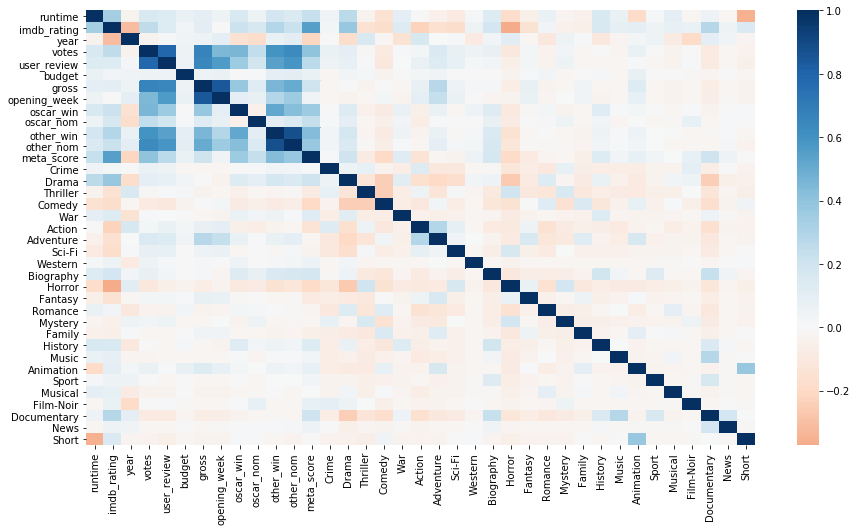

In [53]:
fig, ax = plt.subplots(figsize = (15,8))
sns.heatmap(df.corr(), 
            center = 0, 
           cmap = 'RdBu');

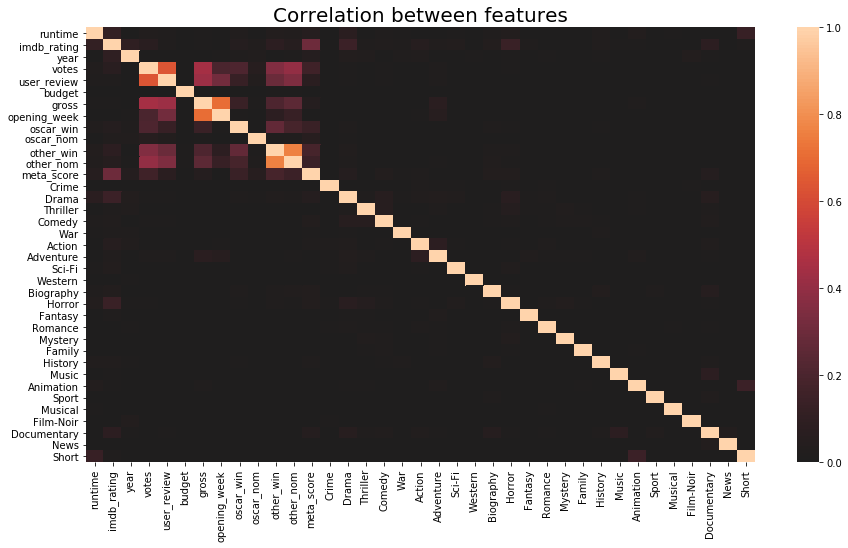

In [54]:
fig, ax = plt.subplots(figsize = (15,8))
sns.heatmap(df.corr()**2,
            center=0
           );
plt.title("Correlation between features", size = 20);

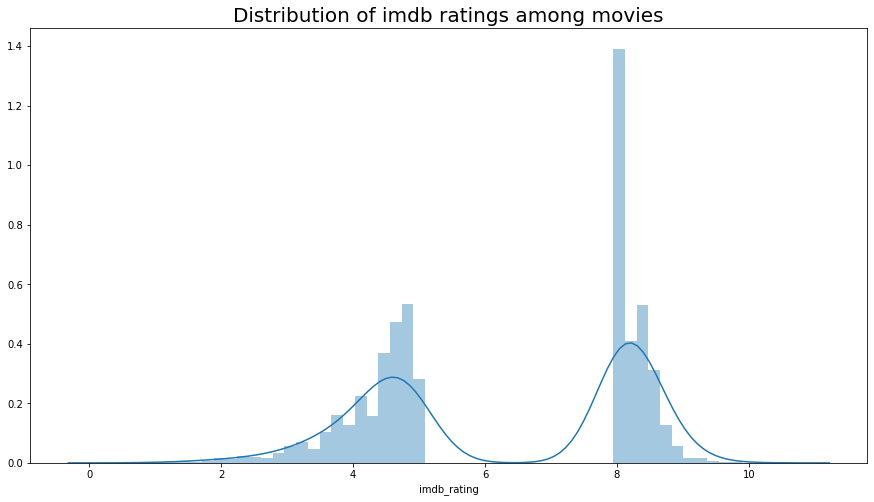

In [55]:
fig, ax = plt.subplots(figsize = (15,8))
sns.distplot(df.imdb_rating,bins = 50);
plt.title("Distribution of imdb ratings among movies", size = 20);

The distribution of the imdb_rating clearly shows how I have chosen two sets of movies. This could give me a result with better r scores. However, it is important to keep in mind that in the real work the distribution do not act similarly. Often you get data sets 


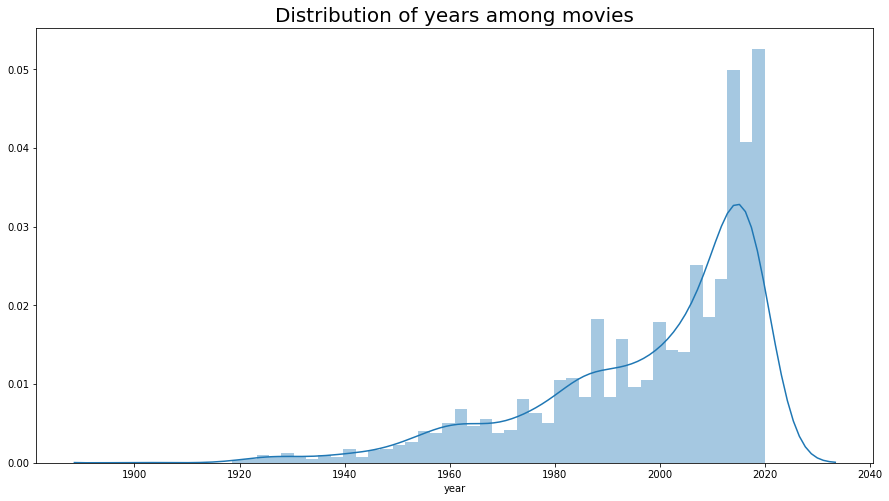

In [56]:
fig, ax = plt.subplots(figsize = (15,8))
sns.distplot(df.year,bins = 50);
plt.title("Distribution of years among movies", size = 20);

Most of the movies are pretty recent.

## Feature Engineering
<a name ="feature_engineering"></a>

In [57]:
## using my custom function to encode country
df = custom_encoder(df, 'country')

## Set year to str
df.year = df.year.astype(str)

df = pd.get_dummies(df, columns=["language", "certificate", "year"], drop_first=True)

df['label'] = df.imdb_rating.apply(lambda x : 1 if x > 7.5 else 0)

y = df.label
X = df.drop(["movie_id", "title", "imdb_rating","label", "summary" ],axis = 1)


In [58]:
X.shape

(2834, 315)

In [59]:
len(y)

2834

### Train-test split
<a name="train_test_split"></a>

In [60]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.25)

#### Feature scaling

In [61]:
from sklearn.preprocessing import minmax_scale, StandardScaler

scale = ["runtime", "votes", "user_review", "critic_review", "budget", "gross","opening_week","meta_score", "other_win", "other_nom"]

scaler = StandardScaler()

In [62]:
X_train[scale] = scaler.fit_transform(X_train[scale])
#X_test[scale] = scaler.fit_transform(X_test[scale])

In [63]:
X_test[scale] = scaler.fit_transform(X_test[scale])

## Creating Models
<a name="creating_models"></a>


In [64]:
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report,precision_recall_curve
from sklearn.tree import DecisionTreeClassifier

##### Finding the best Max_depth

In [65]:
# finding the best max depth for the DecisionTreeClassifier. 

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=11)

max_depth_counter = {}
for i in [1,2,3,4,5,6,7,8, 9,10, None]:
    decision_tree = DecisionTreeClassifier(max_depth=i)
    
    ## assign cv mean with 
    cv_mean = cross_val_score(decision_tree, X_train, y_train, cv=cv, n_jobs = -1).mean()

    ## getting cv mean and max depth in a dict
    max_depth_counter[i] = cv_mean
    print ("Max depth:{}".format(i))
    print (cross_val_score(decision_tree, X_train, y_train, cv=cv, n_jobs = -1).mean())
    
  

##### GridSearch on Random Forest

In [66]:
grid = {
    'n_estimators': [50, 95,100,110],
    'max_features': [1,2,3,4,5,6,'auto'],
    'criterion': ['gini','entropy'],
    'class_weight': ["balanced","balanced_subsample",None]
}



decision_tree = DecisionTreeClassifier(
    max_depth=max(max_depth_counter, key = max_depth_counter.get))

random_forest = RandomForestClassifier(decision_tree)
grid_model = GridSearchCV(random_forest, grid, )

grid_model.fit(X_train, y_train)
grid_model.best_params_

{'class_weight': 'balanced_subsample',
 'criterion': 'gini',
 'max_features': 'auto',
 'n_estimators': 110}

In [67]:
print (grid_model.best_params_)
print (grid_model.best_score_)

In [68]:
grid_model

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=DecisionTreeC...
                                              n_jobs=None, oob_score=False,
                                    

##### Create Random Forest Model using the best param_ from GridSearch

In [69]:
random_forest_model = RandomForestClassifier(max_features = grid_model.best_params_["max_features"],\
                            n_estimators = grid_model.best_params_["n_estimators"],\
                            criterion = grid_model.best_params_["criterion"],\
                            class_weight = grid_model.best_params_["class_weight"])
random_forest_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=110, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [70]:
## Predict y_train for X_train
y_pred = random_forest_model.predict(X_test)

### Result Metrics
<a name="result_metrics"></a>

In [71]:
# printing confision matrix
pd.DataFrame(confusion_matrix(y_test,y_pred),\
            columns=["Predicted high", "Predicted low"],\
            index=["is high","is low"] )

,Predicted high,Predicted low
is high,320,25
is low,3,361


In [72]:
print (classification_report(y_test, y_pred, labels=random_forest_model.classes_))

In [73]:
# Printing accuracy Score
print (accuracy_score(y_test, y_pred))

### Feature Importance
<a name="feature_importance"></a>

In [74]:
# Get features Gini scores
feature_importances = pd.DataFrame(random_forest_model.feature_importances_, 
                                   index = X_train.columns, 
                                   columns=['importance'])

feature_importances[feature_importances['importance']!=0].sort_values(by='importance', ascending=False).head(10)

,importance
runtime,0.096204
meta_score,0.091236
other_win,0.088065
user_review,0.053687
language_English,0.053065
votes,0.052834
critic_review,0.045019
Documentary,0.040162
USA,0.035724
Horror,0.035355


### ROC/AUC CURVE
<a name="roc_auc_curve"></a>

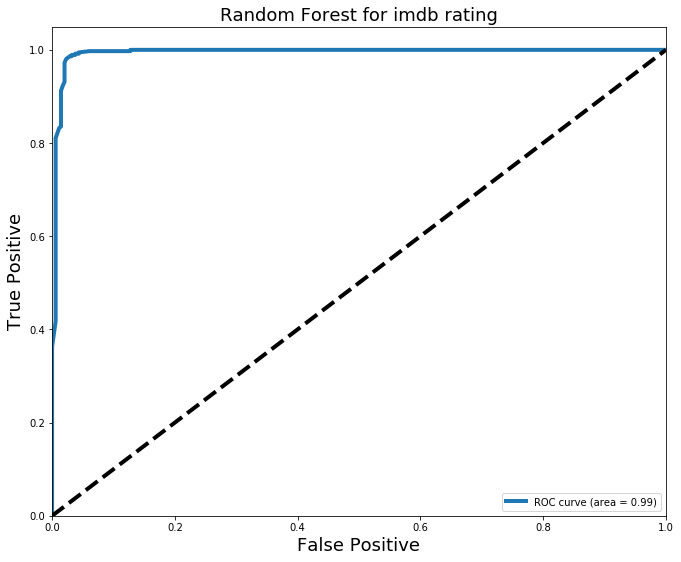

In [75]:
Y_score = grid_model.best_estimator_.predict_proba(X_test)[:,1]


# For class 1, find the area under the curve
FPR, TPR, _ = roc_curve(y_test, Y_score)
ROC_AUC = auc(FPR, TPR)
"""
PREC, REC, _ = precision_recall_curve(y_test, Y_score)
PR_AUC = auc(REC, PREC)"""

# Plot of a ROC curve for class 1 (has_cancer)
plt.figure(figsize=[11,9])
plt.plot(FPR, TPR, label='ROC curve (area = %0.2f)' % ROC_AUC, linewidth=4)
#plt.plot(REC, PREC, label='PR curve (area = %0.2f)' % PR_AUC, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive', fontsize=18)
plt.ylabel('True Positive', fontsize=18)
plt.title('Random Forest for imdb rating', fontsize=18)
plt.legend(loc="lower right")
plt.show()

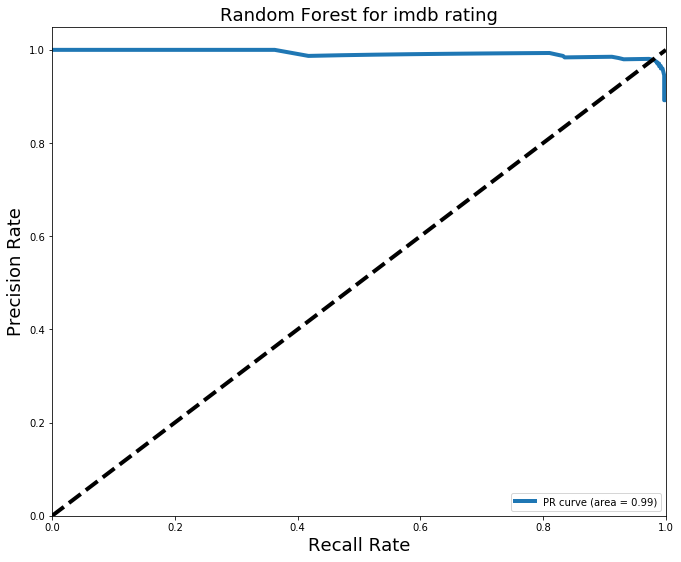

In [76]:
Y_score = grid_model.best_estimator_.predict_proba(X_test)[:,1]


# For class 1, find the area under the curve
PREC, REC, _ = precision_recall_curve(y_test, Y_score)
PR_AUC = auc(REC, PREC)

# Plot of a ROC curve for class 1 (has_cancer)
plt.figure(figsize=[11,9])
plt.plot(REC, PREC, label='PR curve (area = %0.2f)' % PR_AUC, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall Rate', fontsize=18)
plt.ylabel('Precision Rate', fontsize=18)
plt.title('Random Forest for imdb rating', fontsize=18)
plt.legend(loc="lower right")
plt.show()

# Wrapping Up
<a name="wrapping_up"></a>

My model seems to perform too well. One of the reasons could be the way I collected data. I hypothesis is that I was biased while collecting data. The way I web-scraped and collected my data points, there was a huge difference between the two types of data which is unlikely in the real world data problems. This is something to think about for the upcoming projects. 

### Next..
<a name="next"></a>

I believe one of the reasons why my model was giving me really good results is because of the way I collected data from the beginning. While web scraping I basically collected two type of movies. First with imdb_rating over 8 and then imdb_rating below 5. Since there is a big gap in the rating, My model was able to predict too well. This is unlikely in the real world. Therefore, my next procedure would be to web scrape again but this time I should have more variety in the rating while scraping since it is my target variable. Also I would like to work with Actors, Director and Writers as a part of NLP for the next trial. 

